<a href="https://colab.research.google.com/github/FIT3164Group1/Project/blob/main/Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Mount Project Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install split-folders tqdm
import splitfolders

# Split dataset into training, testing and validation sets
splitfolders.ratio(
    input='/content/drive/MyDrive/Dataset', #
    output='/content/drive/MyDrive/output',
    seed=1337,
    ratio=(0.8,0.1,0.1),
    group_prefix=None
)


Copying files: 2313 files [10:21,  3.72 files/s]


In [1]:
from tensorflow import keras

# Import training data
train_ds = keras.utils.image_dataset_from_directory(
    directory='/content/drive/MyDrive/output/train',
    labels='inferred',
    label_mode='int', #sparse_categorical_crossentropy
    class_names=['MSI', 'MSS'],
    color_mode='rgb',
    batch_size=32,
    image_size=(224,224),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False
)

# Import validation data 
validate_ds = keras.utils.image_dataset_from_directory(
    directory='/content/drive/MyDrive/output/val',
    labels='inferred',
    label_mode='int', #sparse_categorical_crossentropy
    class_names=['MSI', 'MSS'],
    color_mode='rgb',
    batch_size=32,
    image_size=(224,224),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False
)

# Import testing data
test_ds = keras.utils.image_dataset_from_directory(
    directory='/content/drive/MyDrive/output/test',
    labels='inferred',
    label_mode='int', #sparse_categorical_crossentropy
    class_names=['MSI', 'MSS'],
    color_mode='rgb',
    batch_size=32,
    image_size=(224,224),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False
)

AttributeError: module 'tensorflow.keras.utils' has no attribute 'image_dataset_from_directory'

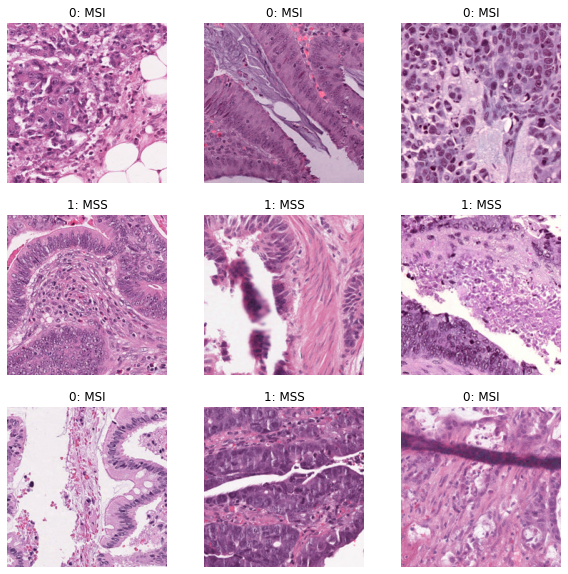

In [46]:
import matplotlib.pyplot as plt
class_names = train_ds.class_names

# Plot subset of images in training data
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(str(labels[i].numpy())+ ': '+ class_names[labels[i]])
    plt.axis("off")

In [ ]:
# Print shape of training data
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [ ]:
from keras.preprocessing.image import ImageDataGenerator

# Generate batches of augmented data in real-time
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255) #Only re-scale test data (i.e. no augmentations)

train_generator = train_datagen.flow_from_directory(
        'output_med/train',
        target_size=(224, 224),
        batch_size=32,
        class_mode='sparse')

validate_generator = test_datagen.flow_from_directory(
        'output_med/val',
        target_size=(224, 224),
        batch_size=32,
        class_mode='sparse')

test_generator = test_datagen.flow_from_directory(
        '/content/drive/MyDrive/output/test',
        target_size=(224, 224),
        batch_size=32,
        class_mode='sparse')

In [2]:
def preprocess_and_decode(img_str):
    decoded = tf.io.decode_base64(img_str)
    image = tf.image.decode_jpeg(decoded, channels=3)
    resized = tf.image.resize(image, size=(224, 224))
    return resized / 255

In [25]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Input
import tensorflow as tf

InputLayer = Input(shape = (1,), dtype="string", name="base64_image")
input = Lambda(lambda img : tf.map_fn(lambda im : preprocess_and_decode(im[0]), img, dtype="float32"))(InputLayer)

vgg_model = VGG16(
    include_top=False, 
    input_tensor = input
    )

for layer in vgg_model.layers:
    layer.trainable=False

flat1 = Flatten()(vgg_model.layers[-1].output)
flat1.shape
class1 = Dense(256, activation='relu')(flat1)
output = Dense(1, activation='sigmoid')(class1)

model = Model(inputs = vgg_model.inputs, outputs = output,)
model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# tf_model = tf.saved_model.load('/content/drive/MyDrive/SavedModels/VGG/VGG_MSI_MSS_prediction')
# tf_model.signatures

_SignatureMap({'serving_default': <ConcreteFunction signature_wrapper(*, input_4) at 0x7F769F65AF10>})

In [ ]:
import base64
import numpy as np

with open('/content/drive/MyDrive/Dataset/MSI/blk-AAADECQEWVSD-TCGA-CM-4746-01Z-00-DX1.jpg', "rb") as imageFile:
    base64_bytes = base64.urlsafe_b64encode(imageFile.read())

print(base64_bytes.decode())
# TODO: remove ' ' chars and 'b' prefix from b64 string for REST API
prediction = model.predict([base64_bytes,])


In [7]:
print(prediction)

[[0.57661164]]


In [ ]:
model.summary()
model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(train_generator,
                    validation_data = validate_generator,
                    epochs=2, verbose=1, steps_per_epoch=5)

In [8]:
model.save(
    filepath="/content/drive/MyDrive/SavedModels/VGG/VGG_b64_1",
    save_format="tf"
    )

INFO:tensorflow:Assets written to: /content/drive/MyDrive/SavedModels/VGG/VGG_b64_1/assets


In [ ]:
model.evaluate(
    x=test_generator,
    steps=2
)

2/2 [==============================] - 18s 9s/step - loss: 1.1301 - accuracy: 0.5312


[1.13010573387146, 0.53125]

In [13]:
import sys
if 'google.colab' in sys.modules:
  from google.colab import auth as google_auth
  google_auth.authenticate_user()
else:
  %env GOOGLE_APPLICATION_CREDENTIALS ''

In [ ]:
!curl https://sdk.cloud.google.com | bash

In [ ]:
!gcloud init

In [ ]:
PROJECT_ID = "fit3164-group-1"
BUCKET_NAME= "vgg-model"
BUCKET_LOCATION='AUSTRALIA-SOUTHEAST2'

!gsutil mb -p $PROJECT_ID -l $BUCKET_LOCATION -b on gs://$BUCKET_NAME

Creating gs://vgg-model/...


In [ ]:
DESTINATION_BUCKET_NAME = "vgg-model"
OBJECT_LOCATION = "/content/drive/MyDrive/SavedModels/VGG/VGG_MSI_MSS_prediction"

!gsutil cp -r $OBJECT_LOCATION gs://$DESTINATION_BUCKET_NAME/

In [ ]:
MODEL_NAME="vgg_prediction_model"
REGION='australia-southeast1'

!gcloud ai-platform models create $MODEL_NAME \
  --region=$REGION

Using endpoint [https://australia-southeast1-ml.googleapis.com/]
Created ai platform model [projects/fit3164-group-1/models/vgg_prediction_model].


In [ ]:
FRAMEWORK="TENSORFLOW"
REGION='australia-southeast1'
MODEL_NAME="vgg_prediction_model"
MODEL_DIR="gs://vgg-model/VGG_MSI_MSS_prediction"
VERSION_NAME="v1_0"

!gcloud ai-platform versions create $VERSION_NAME \
  --model=$MODEL_NAME \
  --origin=$MODEL_DIR \
  --runtime-version=2.5 \
  --framework=$FRAMEWORK \
  --python-version=3.7 \
  --region=$REGION

Using endpoint [https://australia-southeast1-ml.googleapis.com/]


In [ ]:
# JSON prediction

# Import the base64 encoding library.
import tensorflow as tf
from tensorflow import keras

jpeg_data = open(
    file='/content/drive/MyDrive/Dataset/MSI/blk-AAADECQEWVSD-TCGA-CM-4746-01Z-00-DX1.jpg',
    mode='rb',
    encoding=None
).read()

# jpeg_data = tf.keras.utils.load_img(
#     '/content/drive/MyDrive/Dataset/MSI/blk-AAADECQEWVSD-TCGA-CM-4746-01Z-00-DX1.jpg'
# )

# jpeg_data = tf.keras.utils.img_to_array(jpeg_data)/255



In [22]:
import json

with open('/content/drive/MyDrive/Dataset/MSI/blk-AAADECQEWVSD-TCGA-CM-4746-01Z-00-DX1.jpg', "rb") as imageFile:
    base64_bytes = base64.urlsafe_b64encode(imageFile.read())

data = {
    "instances": [
      [str(base64_bytes.decode())]
  ]
}

with open('/content/drive/MyDrive/request.json', 'w') as outfile:
    json.dump(data, outfile)

In [ ]:
# Make prediction
MODEL_NAME="vgg_prediction_model"
MODEL_VERSION="v1_0"


!gcloud ai-platform predict \
--model $MODEL_NAME \
--version $MODEL_VERSION \
--json-request '/content/drive/MyDrive/request.json'

In [ ]:
DATA_FORMAT="text" # JSON data format
INPUT_PATHS='gs://vgg-model/request.json'
OUTPUT_PATH='gs://vgg-model/'
MODEL_NAME="vgg_prediction_model"
VERSION_NAME="vgg_prediction_model"
REGION='australia-southeast1'
MODEL_DIR="gs://vgg-model/VGG_MSI_MSS_prediction"
JOB_NAME="job1"
RUNTIME_VERSION="2.1"

!gcloud ai-platform jobs submit prediction $JOB_NAME \
    --model-dir $MODEL_DIR \
    --input-paths $INPUT_PATHS \
    --output-path $OUTPUT_PATH \
    --region $REGION \
    --data-format $DATA_FORMAT \
    --runtime-version $RUNTIME_VERSION

In [ ]:
!gcloud ai-platform jobs describe job1